In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import sys
import numpy as np
import re
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from os import listdir
import pandas as pd
from tensorflow import keras
from time import time
from tqdm import tqdm
from keras import backend as K
import albumentations as Alb

In [3]:
tf.__version__

'2.6.4'

(1500, 1500, 3)


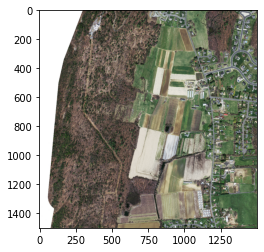

In [4]:
# Checking image
img = plt.imread('../input/massachusetts-roads-dataset/tiff/train/10078705_15.tiff')
print(img.shape)

plt.imshow(img)

Image Interpolation

In [5]:
def bicubic_resize_image( image, height, width ):

#   '''Bicubic interpolation method to convert small image to enlarged image
#     Parameters:
#     img (numpy.ndarray): Small image
#     height, width: resizing image dimension
#     Returns:
#     numpy.ndarray: Resized image
#     '''


  img_height , img_width , channel= image.shape

  resized_image_arr = np.zeros((height, width, channel), dtype = np.uint8 )

  for k in range(channel):
    for i in range(img_height):
      for j in range(img_width):
        
        # Getting the coordinates of nearby values
        xm = (i+0.5) * ( img_height / height ) - 0.5
        ym = (j+0.5) * ( img_width / width ) - 0.5

        xi = np.floor( xm )
        yi = np.floor( ym )

        u = xm - xi
        v = ym - yi


        # Going through all nearby 16 values

        out = 0
        for n in range(-1, 3):
          for m in range(-1, 3):
              if ((xi + n < 0) or (xi + n >= img_width) or (yi + m < 0) or (yi + m >= img_height )):
                  continue

              out += (img[xi+n, yi+m, k] * (W(u - n) * W(v - m)))

        # x = [(xi - 1), xi, (xi + 1), (xi + 2)]
        # y = [(yi - 1), yi, (yi + 1), (yi + 2)]
        # if ((x[0] >= 0) and (x[3] < img.shape[1]) and (y[0] >= 0) and (y[3] < img.shape[0])):
        #     dist_x0 = W(x[0] - xm)
        #     dist_x1 = W(x[1] - xm)
        #     dist_x2 = W(x[2] - xm)
        #     dist_x3 = W(x[3] - xm)
        #     dist_y0 = W(y[0] - ym)
        #     dist_y1 = W(y[1] - ym)
        #     dist_y2 = W(y[2] - ym)
        #     dist_y3 = W(y[3] - ym)

        #     out = (img[x[0], y[0], c] * (dist_x0 * dist_y0) +
        #            img[x[0], y[1], c] * (dist_x0 * dist_y1) +
        #            img[x[0], y[2], c] * (dist_x0 * dist_y2) +
        #            img[x[0], y[3], c] * (dist_x0 * dist_y3) +
        #            img[x[1], y[0], c] * (dist_x1 * dist_y0) +
        #            img[x[1], y[1], c] * (dist_x1 * dist_y1) +
        #            img[x[1], y[2], c] * (dist_x1 * dist_y2) +
        #            img[x[1], y[3], c] * (dist_x1 * dist_y3) +
        #            img[x[2], y[0], c] * (dist_x2 * dist_y0) +
        #            img[x[2], y[1], c] * (dist_x2 * dist_y1) +
        #            img[x[2], y[2], c] * (dist_x2 * dist_y2) +
        #            img[x[2], y[3], c] * (dist_x2 * dist_y3) +
        #            img[x[3], y[0], c] * (dist_x3 * dist_y0) +
        #            img[x[3], y[1], c] * (dist_x3 * dist_y1) +
        #            img[x[3], y[2], c] * (dist_x3 * dist_y2) +
        #            img[x[3], y[3], c] * (dist_x3 * dist_y3))


        resized_image_arr[i, j, k] = np.clip(out, 0, 255)

  resized_image = Image.fromarray( resized_image_arr )

  return resized_image


In [ ]:
def imgcrop(input, xPieces, yPieces):
    filename, file_extension = os.path.splitext(input)
#     print(filename)
#     print(file_extension)
    im = Image.open(input)
    imgwidth, imgheight = im.size
    height = imgheight // yPieces
    width = imgwidth // xPieces
    for i in range(0, yPieces):
        for j in range(0, xPieces):
            box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
            a = im.crop(box)
            try:
                a.save("images/" + filename + "-" + str(i) + "-" + str(j) + file_extension)
            except:
                pass

In [6]:
def buildDataset( PATH ):
    data = []
    filenames = sorted(listdir(PATH))
    
    for fileName in filenames:
        data.append( PATH + '/' + fileName )
    
    return data

In [7]:
transform = Alb.Compose([
    Alb.HorizontalFlip(p=0.5),
    Alb.Blur(blur_limit = 5, p = 0.85)
])
IMG_SIZE = (512, 512)

In [8]:
def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=100, 1)
    return t_mask

def map_function(img, mask):
    img, mask = plt.imread(img.decode()), plt.imread(mask.decode())
    img = op.resize(img, IMG_SIZE)
    mask = op.resize(mask, IMG_SIZE)
    mask = modify_mask(mask)
    
    img = img/255.0
    transformed = transform(image=img, mask=mask)
    img = transformed['image']
    mask = transformed['mask']
    
    return img.astype(np.float64), mask.astype(np.float64)

In [9]:
BATCH_SIZE = 4

def create_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

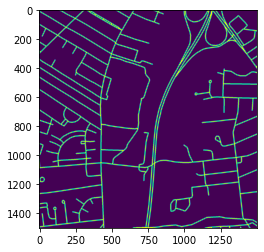

In [10]:
img = plt.imread('../input/massachusetts-roads-dataset/tiff/train_labels/10828810_15.tif')
img = modify_mask(img)
plt.imshow(img)

In [11]:
trainSatImage = buildDataset("../input/massachusetts-roads-dataset/tiff/train")
trainMaskImage = buildDataset("../input/massachusetts-roads-dataset/tiff/train_labels")
testSatImage = buildDataset("../input/massachusetts-roads-dataset/tiff/test")
testMaskImage = buildDataset("../input/massachusetts-roads-dataset/tiff/test_labels")
valSatImage = buildDataset("../input/massachusetts-roads-dataset/tiff/val")
valMaskImage = buildDataset("../input/massachusetts-roads-dataset/tiff/val_labels")

In [12]:
dfTrain = pd.DataFrame({
    'Image': trainSatImage,
    'Mask': trainMaskImage
})
dfTest = pd.DataFrame({
    'Image': testSatImage,
    'Mask': testMaskImage
})
dfVal = pd.DataFrame({
    'Image': valSatImage,
    'Mask': valMaskImage
})

In [13]:
trainDataset = create_dataset( dfTrain )
validationDataset = create_dataset( dfVal )

2022-11-14 11:01:25.329963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 11:01:25.330952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 11:01:25.771581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 11:01:25.772455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 11:01:25.773285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

trainDataset Image Visualization

2022-11-14 11:01:39.595320: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


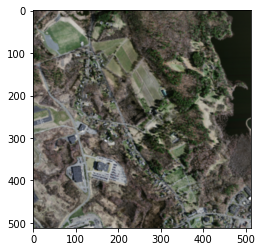

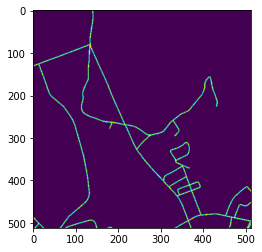

In [14]:
img, mask = next(iter(trainDataset))
# img.shape, mask.shape
plt.imshow(img[3])
plt.show()
plt.imshow(mask[3])
plt.show()

Model Architecture

In [15]:
# Batch BatchNormalization Layer
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

# Convoultion Layer
def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

# Encoding First layer 
def startingLayer(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

# Residual Layer
def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

# Upsamling layer to be used to get image back
def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [16]:
imgSize = 512
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((imgSize, imgSize, 3))
    
    ## Encoder
    e0 = inputs
    e1 = startingLayer(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [17]:

def loss_function(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    intersectionArea =  (2.0 * intersection + 1.0 ) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0 )
    loss = 1.0 - intersectionArea

    return loss


def EvalMetric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    intersectionArea =  (2.0 * intersection + 1.0 ) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0 )

    return intersectionArea

Place Mask on Image

In [18]:
color = [66, 255, 73]
color = [i/255.0 for i in color]

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

Model Training

In [19]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=loss_function, metrics=[EvalMetric])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Load weights

In [20]:
model.load_weights("../input/resnet-model/ResUNetEpoch10.h5")

In [20]:
train_steps = len(trainSatImage)//BATCH_SIZE
valid_steps = len(valSatImage)//BATCH_SIZE

epochs = 2

model.fit_generator(trainDataset, validation_data=validationDataset, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2


2022-11-13 14:38:46.769395: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


277/277 [==============================] - 134s 411ms/step - loss: 0.6058 - EvalMetric: 0.3942 - val_loss: 0.7731 - val_EvalMetric: 0.2269
Epoch 2/2
277/277 [==============================] - 116s 417ms/step - loss: 0.4497 - EvalMetric: 0.5503 - val_loss: 0.5731 - val_EvalMetric: 0.4269


In [21]:
model.save_weights("ResUNetEpoch2.h5")

Test Data

In [21]:
# Test Data
def make_pred_good(pred):
#     pred = pred.numpy()
    pred = pred[0][:, :, :]
    pred = np.repeat(pred, 3, 2)
    return pred

def predictRoad( model, imagePath, maskPath ):
    plt.figure(figsize = (12,10))
    img = plt.imread(imagePath)
    mask = plt.imread(maskPath)
    mask = modify_mask(op.resize(mask, IMG_SIZE))
    img = (img/255.0)
    transformed = transform(image=img, mask=mask)
    img = transformed['image']
    mask = transformed['mask']
    
    img = np.expand_dims(op.resize(img, (512, 512)), 0)
    img = img.astype(np.float32)
    
    pred = make_pred_good(model(img))
    mask = make_pred_good(np.expand_dims(mask, axis = 0))
    
    plt.subplot(1,3,1)
    plt.title("Satellite")
    plt.imshow(img[0])
    plt.subplot(1,3,2)
    plt.title('Actual mask')
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.title('Predicted mask')
    pred = placeMaskOnImg(img[0], pred)
    plt.imshow(pred)
    
    plt.show()
    

2022-11-14 11:03:21.541836: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


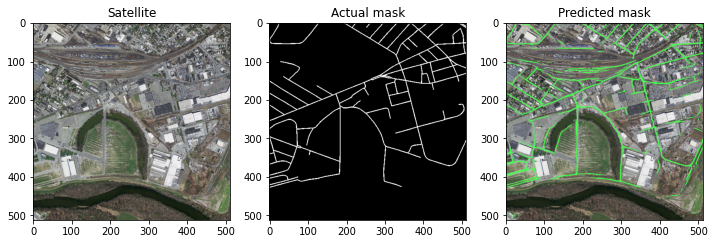

In [22]:
predictRoad( model, '../input/massachusetts-roads-dataset/tiff/test/10828720_15.tiff', '../input/massachusetts-roads-dataset/tiff/test_labels/10828720_15.tif')